In [218]:
#https://www.youtube.com/watch?v=ujId4ipkBio
#https://www.youtube.com/watch?v=MpIi4HtCiVk&t=113s
import os
from pathlib import Path
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
import datetime
import time
from dotenv import load_dotenv
from textblob import TextBlob
import sys, tweepy
import matplotlib.pyplot as plt
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy import displacy
import seaborn as sns
from wordcloud import WordCloud

In [219]:
# Load .env enviroment variables
load_dotenv()

True

In [220]:
# assign the values accordingly
consumerKey = os.getenv("consumer_key")
consumerSecret = os.getenv("consumer_secret")
accessToken = os.getenv("access_token")
accessTokenSecret = os.getenv("access_token_secret")

# authorization of consumer key and consumer secret
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)

# set access to user's access key and access secret
auth.set_access_token(accessToken, accessTokenSecret)

start_date = datetime.datetime(2021, 5, 30)
end_date = datetime.datetime(2021, 5, 31)

# calling the api
api = tweepy.API(auth)
#results = api.search_full_archive('project2', 'bitcoin', fromDate=202105300000, toDate=202105310000, maxResults=100)
#This code above is for a full archive search, not a cursor search

In [221]:
#This is cursor search, not full search
#Using 200 latest tweets of Bitcoin as an example
number_of_tweets = 200
tweets = []
time = []
for i in tweepy.Cursor(api.search, q="Bitcoin", tweet_mode="extended").items(number_of_tweets):
    tweets.append(i.full_text)
    time.append(i.created_at)

In [222]:
df = pd.DataFrame({'tweets':tweets, 'time':time})

In [223]:
df.head()

,tweets,time
0,RT @AirdropDet: 🔍 New #Airdrop: Breezecoin\n\n...,2021-06-01 15:11:25
1,Weak Hands Shaken Out: Short-Term Bitcoin Hold...,2021-06-01 15:11:25
2,My view on current Bitcoin market structure: h...,2021-06-01 15:11:25
3,@TUPA_App @PancakeSwap Good project for all us...,2021-06-01 15:11:24
4,RT @girlgone_crypto: Raise your hand if you th...,2021-06-01 15:11:24


In [224]:
#Cleaning the text
#Create a function to clean the tweets
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removing @mentions
    text = re.sub(r'#', '', text) #Removing the # symbol
    text = re.sub(r'RT[\s]+', '', text) #Removing RT
    text = re.sub(r'https?:\/\/\S+', '', text) #Removing the hyper link
    text = re.sub(r':', '', text) #Removing the : symbol
    return text

#Cleaning the text by applying the function cleanTxt
df['tweets'] = df['tweets'].apply(cleanTxt)

#Showing the cleaned text
df.head()

,tweets,time
0,🔍 New Airdrop Breezecoin\n\n💲Reward Up to 135...,2021-06-01 15:11:25
1,Weak Hands Shaken Out Short-Term Bitcoin Holde...,2021-06-01 15:11:25
2,My view on current Bitcoin market structure,2021-06-01 15:11:25
3,"_App Good project for all user and follower, ...",2021-06-01 15:11:24
4,_crypto Raise your hand if you think 100k bitc...,2021-06-01 15:11:24


In [225]:
#Create a function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Create a fucntion to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Create two new columns
df['Subjectivity'] = df['tweets'].apply(getSubjectivity)
df['Polarity'] = df['tweets'].apply(getPolarity)

#Show the new dataframe with the two new columns
df.head()

,tweets,time,Subjectivity,Polarity
0,🔍 New Airdrop Breezecoin\n\n💲Reward Up to 135...,2021-06-01 15:11:25,0.454545,0.136364
1,Weak Hands Shaken Out Short-Term Bitcoin Holde...,2021-06-01 15:11:25,0.625000,-0.375000
2,My view on current Bitcoin market structure,2021-06-01 15:11:25,0.400000,0.000000
3,"_App Good project for all user and follower, ...",2021-06-01 15:11:24,0.362500,0.350000
4,_crypto Raise your hand if you think 100k bitc...,2021-06-01 15:11:24,1.000000,0.000000


In [226]:
#Preparing data to get a bar chart of top 20 words

#Splitting the sentences into words
list_of_sentences = [sentence for sentence in df.tweets]
lines = []
for sentence in list_of_sentences:
    words = sentence.split()
    for w in words:
        lines.append(w)

#Removing punctuation using regular expression
lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]
lines2 = []
for word in lines:
    if word != '':
        lines2.append(word)
#print(lines2)

#Reducing words to its word stem
from nltk.stem.snowball import SnowballStemmer
s_stemmer = SnowballStemmer(language='english')
stem = []
for word in lines2:
    stem.append(s_stemmer.stem(word))

#Removing all stop words
stem2 = []
for word in stem:
    if word not in nlp.Defaults.stop_words:
        stem2.append(word)

#Using value counts to group all distinct words
df2 = pd.DataFrame(stem2)
df2 = df2[0].value_counts()
df2.head()

bitcoin    155
4           77
crypto      64
airdrop     45
year        41
Name: 0, dtype: int64

C:\Users\ooika\anaconda3\envs\pyvizenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


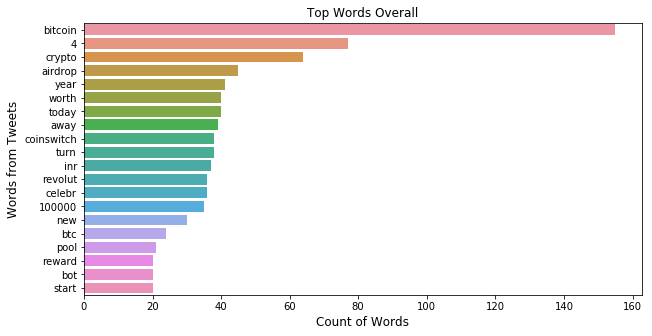

In [227]:
#Choosing top 20 words and plotting it in a barchart
df2 = df2[:20,]
plt.figure(figsize=(10,5))
sns.barplot(df2.values, df2.index, alpha=1)
plt.title("Top Words Overall")
plt.ylabel('Words from Tweets', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

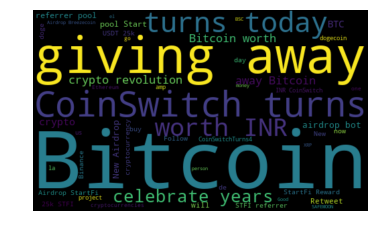

Wordcloud is almost simlar to top 20 words


In [228]:
#Getting a string of text to generate the word cloud
allWords = ' '.join(twts for twts in df['tweets'])

# Generate wordcloud
wc = WordCloud(width=500, height=300, random_state=21, max_words=50, max_font_size=120).generate(allWords)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

print('Wordcloud is almost simlar to top 20 words')

In [229]:
#Creating the sentiment values
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    elif score > 0:
        return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)
df.head()

,tweets,time,Subjectivity,Polarity,Analysis
0,🔍 New Airdrop Breezecoin\n\n💲Reward Up to 135...,2021-06-01 15:11:25,0.454545,0.136364,Positive
1,Weak Hands Shaken Out Short-Term Bitcoin Holde...,2021-06-01 15:11:25,0.625000,-0.375000,Negative
2,My view on current Bitcoin market structure,2021-06-01 15:11:25,0.400000,0.000000,Neutral
3,"_App Good project for all user and follower, ...",2021-06-01 15:11:24,0.362500,0.350000,Positive
4,_crypto Raise your hand if you think 100k bitc...,2021-06-01 15:11:24,1.000000,0.000000,Neutral


In [230]:
# Print all positive tweets
j=1
sortedDF = df.sort_values(by=['Polarity'])
for i in range(0, sortedDF.shape[0]):
    if(sortedDF['Analysis'][i] == 'Positive'):
        print(str(j) + ') '+sortedDF['tweets'][i])
        print()
        j = j+1

#114 out of 200 tweets are positive.

1)  🔍 New Airdrop Breezecoin

💲Reward Up to 135 BRZE [~$2)+115k BRZE [~$1600] referrer pool

🔴 Start the airdrop bot https…

2) _App  Good project for all user and follower, i hope succes for this project, and i hope this project succes for the future

_Karsimah  

Crypto doge Airdrop Elon Dogecoin PancakeSwap BSC bitcoin

3)  Very Good Project Crypto Bitcoin Binance  

4)   is touring incomplete so it is pretty darn safe. 
NativeDeFi enabled on Bitcoin ;)

Grab your $dfi and join that incredible, fast growing ecosystem today.

5)  🔍 New Airdrop StartFi

💲Reward Up to 1 USDT + 25k STFI [~$5000] referrer pool

🔴 Start the airdrop bot 

6)  Really amazing to see how far we've come with the real world adoption of IOTA. 

The potential use cases of IOTA in IoT…

7)  🔍 New Airdrop StartFi

💲Reward Up to 1 USDT + 25k STFI [~$5000] referrer pool

🔴 Start the airdrop bot 

8)  CoinSwitch turns 4 today🚀

As we celebrate 4 years of crypto revolution, we are giving away Bitcoin  worth INR 100000…

In [231]:
# Print all negative tweets
j=1
sortedDF = df.sort_values(by=['Polarity'], ascending='False')
for i in range(0, sortedDF.shape[0]):
    if(sortedDF['Analysis'][i] == 'Negative'):
        print(str(j) + ') '+sortedDF['tweets'][i])
        print()
        j = j+1
        
#13 out of 200 tweets are negative

1) Weak Hands Shaken Out Short-Term Bitcoin Holders Selling At A Loss 

2)  $75 to one random person in 12hrs

&amp; follow me + 👇

1- Go to this link

2- Click on the star 🌟
3…

3)  The bitcoin community forced a central bank and a publicly traded company to succumb to the will of the people yesterday.…

4) _Archive 😂 Missing out on Bitcoin kills your soul!  Just HODL 😉 

5)  So as you can clearly see, bitcoin's "scarcity" turns out to be a big fraud after all. Even an imbecile could understan…

6)  dogecoin 😫SELL ALL BITCOIN AND DOGE  NOW BITCOIN KEEPS GETTING REJECTED  AND WILL GO DOWN INTO TO LOW 20,S ONCE THE CH…

7) _Sisters So since we are in recovery and Bitcoin going up and $6Trillion into the economy with FAKE MONEY... new all time highs? Realistic price predictions anyone?

8) 😫SELL ALL BITCOIN AND DOGE  NOW BITCOIN KEEPS GETTING REJECTED  AND WILL GO DOWN INTO TO LOW 20,S ONCE THE CHASHOWS THE  DOUBLE DEATH CROSS ☠️☠️ OCCURING IN 2 DAYS😡 THIS IS WHY IT KEEPS GETTING REJECTE

Can visually see the distribution of the dots. Dots at the 0 line represent neutral tweets. Dots on the left represent negative tweets, and right represents positive


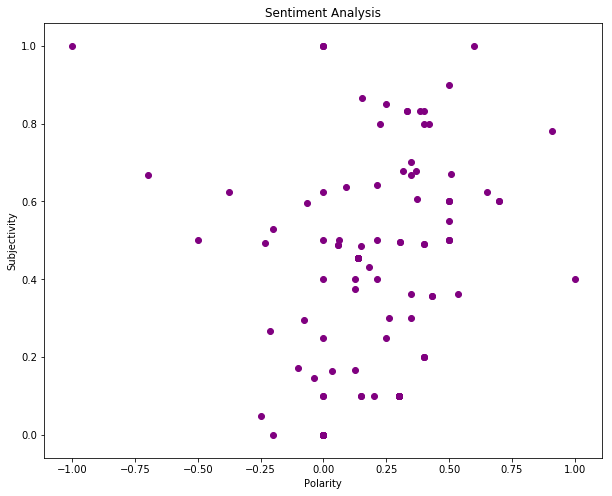

In [232]:
# Plot the polarity and subjectivity
plt.figure(figsize=(10,8))
for i in range(0, df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color='purple')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
print('Can visually see the distribution of the dots. Dots at the 0 line represent neutral tweets. Dots on the left represent negative tweets, and right represents positive')

In [235]:
# Get % of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['tweets']
positive = round((ptweets.shape[0]/df.shape[0])*100,1)
print(positive)
print('114 out of 200 tweets are positive, correlating to f{positive}% positive tweets')
#Need help writing this

# Get % of negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['tweets']
negative = round((ntweets.shape[0]/df.shape[0])*100,1)
print(negative)
print('13 out of 200 teeets are positive, correlating to f{(negative)}% positive tweets')

57.0
114 out of 200 tweets are positive, correlating to f{positive}% positive tweets
6.5
13 out of 200 teeets are positive, correlating to f{(negative)}% positive tweets


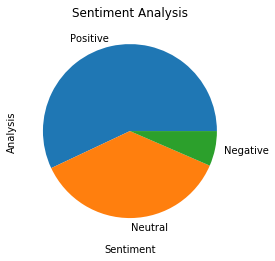

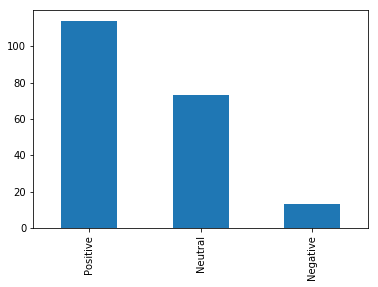

In [234]:
# Show the value counts
df['Analysis'].value_counts()

# Plot and visualise the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind='pie')
plt.show()
df['Analysis'].value_counts().plot(kind='bar')
plt.show()